In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pankajlamgria","key":"1a45498f53b0668c01ddc274770b9cdb"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 89% 196M/219M [00:01<00:00, 222MB/s]
100% 219M/219M [00:01<00:00, 201MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp "/content/rice-image-dataset.zip" "/content/drive/MyDrive/rice-image-dataset.zip"

In [5]:
!unzip "rice-image-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
def loadData(path):
  xdata=[]
  label=[]
  dir_label=os.listdir(path)
  for tag in dir_label:
    print(tag)
    for img_label in os.listdir(f"{path}/{tag}"):
      xdata.append(f"{path}/{tag}/{img_label}")
      label.append(tag)
  return xdata,label

In [8]:
x,y=loadData("/content/Rice_Image_Dataset")

Basmati
Ipsala
Arborio
Jasmine
.ipynb_checkpoints
Karacadag


In [9]:
indx=np.arange(len(x))
np.random.shuffle(indx)
tempx=[];
tempy=[];
for i in indx:
  tempx.append(x[i])
  tempy.append(y[i])

In [10]:
x=tempx
y=tempy

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=.7,random_state=86)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,train_size=.4,random_state=20)


In [ ]:
print("Train:",len(xtrain),len(ytrain))
print("Test:",len(xtest),len(ytest))
print("Validataion:",len(xval),len(yval))

Train: 52500 52500
Test: 13500 13500
Validataion: 9000 9000


In [13]:
trainDf=pd.DataFrame({"image":xtrain,"label":ytrain})
testDf=pd.DataFrame({"image":xtest,"label":ytest})
valDf=pd.DataFrame({"image":xval,"label":yval})

In [14]:
print(trainDf['label'].value_counts())
print(testDf['label'].value_counts())
print(valDf['label'].value_counts())

Jasmine      10560
Basmati      10552
Ipsala       10499
Karacadag    10464
Arborio      10425
Name: label, dtype: int64
Karacadag    2739
Arborio      2723
Ipsala       2717
Jasmine      2668
Basmati      2653
Name: label, dtype: int64
Arborio      1852
Karacadag    1797
Basmati      1795
Ipsala       1784
Jasmine      1772
Name: label, dtype: int64


In [15]:
labelEnc=LabelEncoder()
ytrain=labelEnc.fit_transform(ytrain)
ytest=labelEnc.fit_transform(ytest)
yval=labelEnc.fit_transform(yval)


In [16]:
xtrain_datagen=ImageDataGenerator(rescale=1./255,featurewise_center=True,
                                 zoom_range=0.2,
                                 shear_range=0.2,
                                 rotation_range=10,
                                 fill_mode="nearest",
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 )
xtest_datagen=ImageDataGenerator(rescale=1./255,featurewise_center=True)
xval_datagen=ImageDataGenerator(rescale=1./255,featurewise_center=True)


In [17]:
train_gen=xtrain_datagen.flow_from_dataframe(
    trainDf,x_col="image",y_col='label',target_size=(100,100),batch_size=32,
    shuffle=True,class_mode='categorical'
)
test_gen=xtest_datagen.flow_from_dataframe(
    testDf,x_col="image",y_col='label',target_size=(100,100),batch_size=32,
    shuffle=False,class_mode='categorical'
)
val_gen=xval_datagen.flow_from_dataframe(
    valDf,x_col="image",y_col='label',target_size=(100,100),batch_size=32,
    shuffle=False,class_mode='categorical'
)

Found 52500 validated image filenames belonging to 5 classes.
Found 13500 validated image filenames belonging to 5 classes.
Found 9000 validated image filenames belonging to 5 classes.


In [ ]:
print(type(train_gen))

<class 'keras.src.preprocessing.image.DataFrameIterator'>


In [18]:
model=keras.Sequential()
model.add(layers.Conv2D(filters=20,kernel_size=(3,3),activation='relu',padding='same',input_shape=(100,100,3)))
model.add(layers.Conv2D(filters=20, kernel_size=(7, 7), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=20,kernel_size=(3,3),activation='relu',dilation_rate=2,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2,strides=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',dilation_rate=2,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2,strides=1))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',dilation_rate=2,padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=2,strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=5,activation='softmax'))

In [37]:
early_stopping=EarlyStopping(
    monitor='accuracy',
    patience=2,
    verbose=1,
    mode='max',
    restore_best_weights=True
)
model_checkpoint=ModelCheckpoint(
    filepath="best_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
model.compile(
    optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy']
)
history=model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=4,
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1641/1641 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.8895
Epoch 1: val_loss improved from inf to 1.93396, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1641/1641 [==============================] - 227s 132ms/step - loss: 0.2894 - accuracy: 0.8895 - val_loss: 1.9340 - val_accuracy: 0.6384
Epoch 2/4
1641/1641 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9516
Epoch 2: val_loss improved from 1.93396 to 0.38520, saving model to best_model.h5
1641/1641 [==============================] - 210s 128ms/step - loss: 0.1350 - accuracy: 0.9516 - val_loss: 0.3852 - val_accuracy: 0.8792
Epoch 3/4
1641/1641 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9660
Epoch 3: val_loss improved from 0.38520 to 0.07588, saving model to best_model.h5
1641/1641 [==============================] - 217s 132ms/step - loss: 0.0977 - accuracy: 0.9660 - val_loss: 0.0759 - val_accuracy: 0.9716
Epoch 4/4
1641/1641 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9719
Epoch 4: val_loss did not improve from 0.07588
1641/1641 [==============================] - 211s 128ms/step - loss: 0.0821 - accuracy:

In [38]:
best_model=load_model('./best_model.h5')
res=best_model.predict(val_gen)
print(res)

282/282 [==============================] - 8s 27ms/step
[[5.69915741e-08 9.98317480e-01 2.71117759e-08 1.68218825e-03
  3.49918025e-07]
 [1.01037547e-02 4.15300764e-03 1.75236510e-05 9.66306150e-01
  1.94196217e-02]
 [8.92391335e-03 3.93367627e-05 1.08235334e-07 9.91014659e-01
  2.19508220e-05]
 ...
 [5.21026379e-07 9.98633564e-01 4.14307664e-07 1.36445544e-03
  1.01596083e-06]
 [9.38190818e-01 5.85541841e-07 3.17824815e-05 1.94493507e-04
  6.15824126e-02]
 [2.57554188e-06 7.92222500e-01 8.89624872e-08 2.07774222e-01
  6.42203361e-07]]


In [39]:
output=np.argmax(res,axis=1)
print(output)
print(yval)

[1 3 3 ... 1 0 1]
[1 3 3 ... 1 0 1]


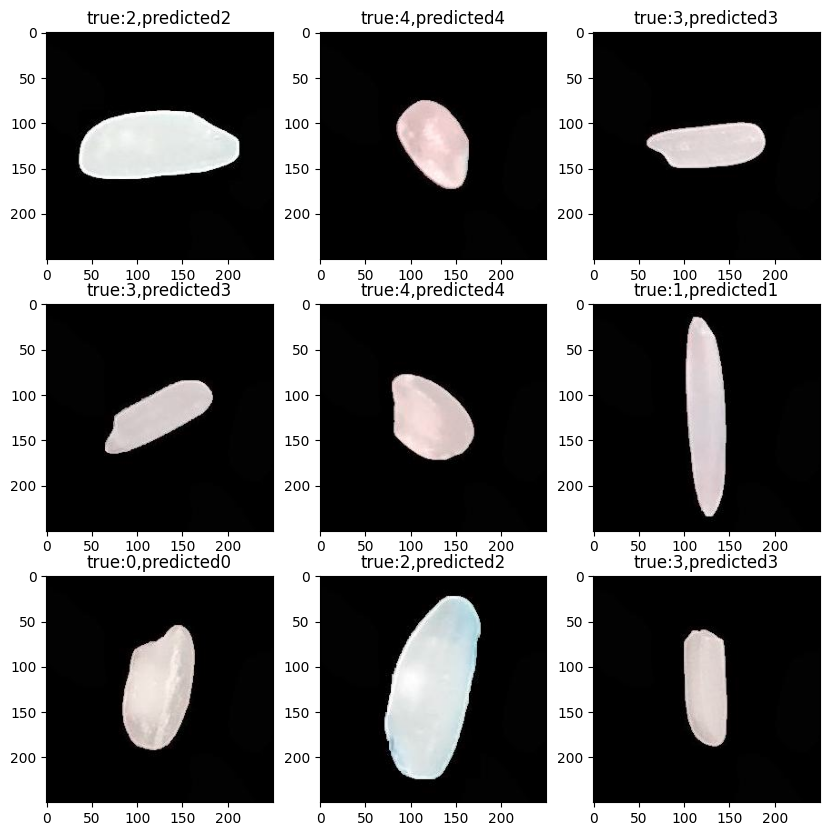

In [ ]:
import cv2
fig=plt.figure(figsize=(10,10))
rows=3
column=3
for i in range(9):
  fig.add_subplot(rows,column,i+1)
  img_arr=cv2.imread(valDf['image'][i])
  plt.imshow(img_arr)
  plt.axis=('off')
  plt.title(f"true:{yval[i]},predicted{output[i]}")

In [40]:
# best_model=load_model("best_model.h5")
train_loss, train_accuracy = best_model.evaluate(train_gen)
val_loss, val_accuracy = best_model.evaluate(val_gen)
test_loss, test_accuracy = best_model.evaluate(test_gen)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

422/422 [==============================] - 13s 30ms/step - loss: 0.0695 - accuracy: 0.9731
train loss: 0.21943852305412292
train accuracy: 0.9223238229751587
------------------------
val loss: 0.0758824273943901
val accuracy: 0.9715555310249329
------------------------
Test loss: 0.06954732537269592
Test accuracy: 0.973111093044281


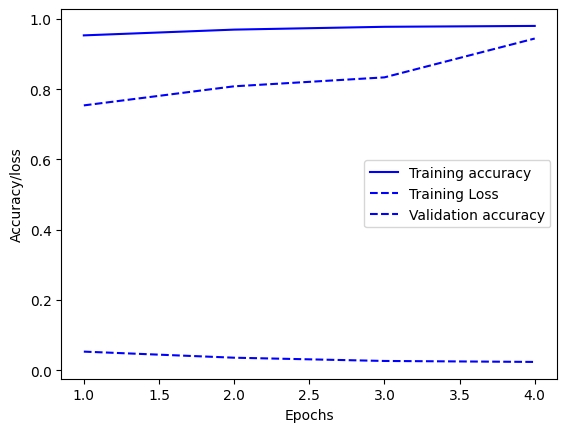

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b-',label="Training accuracy")
plt.plot(epochs,loss,'b--',label="Training Loss")
plt.plot(epochs,val_acc,'b--',label="Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy/loss')
plt.legend()
plt.show()

In [19]:
model_vgg19=keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(100,100,3)
)
model_vgg19.trainable=False
input_layer=keras.layers.Input(shape=(100,100,3))
x=model_vgg19(input_layer,training=False)
x=layers.Flatten()(x)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dropout(0.15)(x)
output=layers.Dense(units=5,activation='softmax')(x)

vgg=keras.Model(inputs=[input_layer],outputs=[output])
vgg.summary()



80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                              

In [20]:
early_stopping=EarlyStopping(
    monitor='accuracy',
    patience=2,
    verbose=1,
    mode='max',
    restore_best_weights=True
)
model_checkpoint=ModelCheckpoint(
    filepath="best_model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
vgg.compile(
    optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy']
)
history2=vgg.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=3,
    callbacks=[early_stopping,model_checkpoint]
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/3
1641/1641 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.9002
Epoch 1: val_loss improved from inf to 0.13981, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1641/1641 [==============================] - 211s 125ms/step - loss: 0.2640 - accuracy: 0.9002 - val_loss: 0.1398 - val_accuracy: 0.9491
Epoch 2/3
1641/1641 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9350
Epoch 2: val_loss did not improve from 0.13981
1641/1641 [==============================] - 205s 125ms/step - loss: 0.1700 - accuracy: 0.9350 - val_loss: 0.2626 - val_accuracy: 0.8928
Epoch 3/3
1641/1641 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9414
Epoch 3: val_loss did not improve from 0.13981
1641/1641 [==============================] - 197s 120ms/step - loss: 0.1549 - accuracy: 0.9414 - val_loss: 0.2370 - val_accuracy: 0.9081


In [21]:
best_model=load_model("best_model.h5")
train_loss, train_accuracy = best_model.evaluate(train_gen)
val_loss, val_accuracy = best_model.evaluate(val_gen)
test_loss, test_accuracy = best_model.evaluate(test_gen)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

422/422 [==============================] - 18s 42ms/step - loss: 0.1441 - accuracy: 0.9496
------------------------
val loss: 0.13981300592422485
val accuracy: 0.9491111040115356
------------------------
Test loss: 0.14412637054920197
Test accuracy: 0.9495555758476257
